# Late Fusion by Reaction Time Groups - BALANCED

This notebook splits trials into reaction time groups with **STRATIFIED SAMPLING** to ensure each subject contributes equally to each group.

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [1]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'POST'  # Change to 'POST' for post-decision analysis
# ============================================================================

import sys
sys.path.append('../..')  # Add project root to path

import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.models.fusion import weighted_late_fusion

np.random.seed(42)
sns.set_style('whitegrid')

print(f"\n{'='*70}")
print(f"RT GROUP (BALANCED) ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


RT GROUP (BALANCED) ANALYSIS: POST-DECISION PERIOD



## 1. Load Pre-Extracted Features


In [2]:
# Load pre-extracted features
with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"\nReaction time stats:")
print(f"  Mean: {merged_df['reaction_time'].mean():.2f}s")
print(f"  Median: {merged_df['reaction_time'].median():.2f}s")
print(f"  Min: {merged_df['reaction_time'].min():.2f}s")
print(f"  Max: {merged_df['reaction_time'].max():.2f}s")


✓ Loaded 11467 trials from 97 subjects
  Features extracted on: 2026-01-01 18:36:39

Reaction time stats:
  Mean: 1.59s
  Median: 1.42s
  Min: 0.14s
  Max: 4.58s


## 2. Create Reaction Time Groups


In [3]:
# Create reaction time groups using median split
rt_median = merged_df['reaction_time'].median()
merged_df['rt_group'] = merged_df['reaction_time'].apply(lambda x: 'Fast' if x <= rt_median else 'Slow')

print(f"\nMedian reaction time: {rt_median:.2f}s")
print("\nReaction time group distribution:")
print(merged_df['rt_group'].value_counts())

for group in ['Fast', 'Slow']:
    group_data = merged_df[merged_df['rt_group'] == group]
    print(f"\n{group} group:")
    print(f"  RT range: {group_data['reaction_time'].min():.2f}s - {group_data['reaction_time'].max():.2f}s")
    print(f"  RT mean: {group_data['reaction_time'].mean():.2f}s")



Median reaction time: 1.42s

Reaction time group distribution:
rt_group
Fast    5734
Slow    5733
Name: count, dtype: int64

Fast group:
  RT range: 0.14s - 1.42s
  RT mean: 1.03s

Slow group:
  RT range: 1.42s - 4.58s
  RT mean: 2.16s


## 3. Apply Stratified Sampling to Balance Subjects


In [4]:
# Apply stratified sampling to balance subjects across RT groups
print("="*80)
print("STRATIFIED SAMPLING: BALANCING SUBJECTS ACROSS RT GROUPS")
print("="*80)

# For each RT group, sample equal number of trials from each subject
balanced_dfs = []

for group in ['Fast', 'Slow']:
    group_data = merged_df[merged_df['rt_group'] == group].copy()
    
    # Find minimum trials per subject in this group
    subject_counts = group_data.groupby('subject_id').size()
    min_trials = subject_counts.min()
    
    print(f"\n{group} RT Group:")
    print(f"  Before balancing: {len(group_data)} trials")
    print(f"  Min trials per subject: {min_trials}")
    print(f"  Max trials per subject: {subject_counts.max()}")
    
    # Sample min_trials from each subject
    balanced_group_data = []
    for subject in group_data['subject_id'].unique():
        subject_data = group_data[group_data['subject_id'] == subject]
        sampled = subject_data.sample(n=min_trials, random_state=42)
        balanced_group_data.append(sampled)
    
    balanced_group_df = pd.concat(balanced_group_data, ignore_index=True)
    balanced_dfs.append(balanced_group_df)
    
    print(f"  After balancing: {len(balanced_group_df)} trials ({min_trials} per subject × {len(subject_counts)} subjects)")
    print(f"  Excluded: {len(group_data) - len(balanced_group_df)} trials")

# Create balanced version of merged_df
merged_df_balanced = pd.concat(balanced_dfs, ignore_index=True)

print(f"\n{'='*80}")
print("OVERALL BALANCING SUMMARY:")
print(f"Original dataset: {len(merged_df)} trials")
print(f"Balanced dataset: {len(merged_df_balanced)} trials")
print(f"Excluded: {len(merged_df) - len(merged_df_balanced)} trials ({(len(merged_df) - len(merged_df_balanced))/len(merged_df)*100:.1f}%)")
print(f"{'='*80}")

# Verify balance
print("\nVerifying balance - Trials per subject per group:")
balanced_subject_dist = merged_df_balanced.groupby(['subject_id', 'rt_group']).size().unstack(fill_value=0)
print(balanced_subject_dist.to_string())


STRATIFIED SAMPLING: BALANCING SUBJECTS ACROSS RT GROUPS

Fast RT Group:
  Before balancing: 5734 trials
  Min trials per subject: 1
  Max trials per subject: 124
  After balancing: 97 trials (1 per subject × 97 subjects)
  Excluded: 5637 trials

Slow RT Group:
  Before balancing: 5733 trials
  Min trials per subject: 5
  Max trials per subject: 127
  After balancing: 485 trials (5 per subject × 97 subjects)
  Excluded: 5248 trials

OVERALL BALANCING SUMMARY:
Original dataset: 11467 trials
Balanced dataset: 582 trials
Excluded: 10885 trials (94.9%)

Verifying balance - Trials per subject per group:
rt_group           Fast  Slow
subject_id                   
0806_1000_539136F     1     5
0806_1000_U9TEJGM     1     5
0811_1000_4LI8GO7     1     5
0811_1000_539136F     1     5
0811_1000_U9TEJGM     1     5
0813_1000_539136F     1     5
0813_1000_9M4VCHG     1     5
0813_1000_U9TEJGM     1     5
0813_1600_539136F     1     5
0813_1600_9M4VCHG     1     5
0813_1600_U9TEJGM     1     5
0816

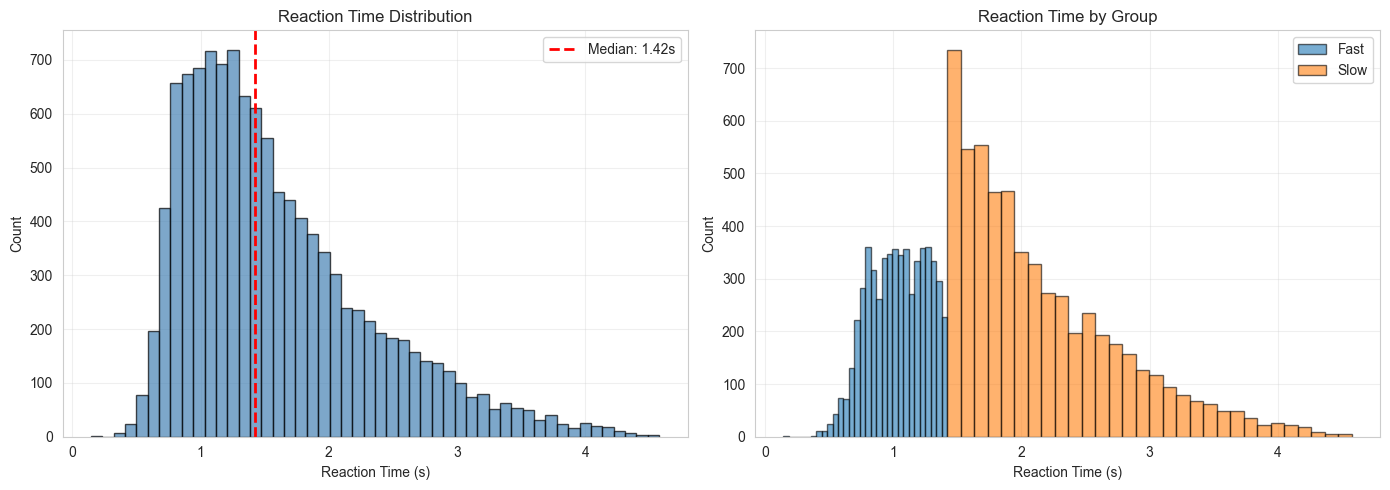

In [5]:
# Visualize RT distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(merged_df['reaction_time'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(rt_median, color='red', linestyle='--', linewidth=2, label=f'Median: {rt_median:.2f}s')
ax.set_xlabel('Reaction Time (s)')
ax.set_ylabel('Count')
ax.set_title('Reaction Time Distribution')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
for group in ['Fast', 'Slow']:
    group_data = merged_df[merged_df['rt_group'] == group]
    ax.hist(group_data['reaction_time'], bins=30, alpha=0.6, label=group, edgecolor='black')
ax.set_xlabel('Reaction Time (s)')
ax.set_ylabel('Count')
ax.set_title('Reaction Time by Group')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Prepare Feature Sets


In [6]:
physio_cols = [c for c in merged_df_balanced.columns if c.endswith('_pre')]
# Exclude reaction_time from behavior features since we're grouping by it
behavior_cols = ['decision_time', 'ev_difference', 
                 'invest_variance', 'ambiguity', 'condition_social', 'risk_premium']
gaze_cols = [c for c in merged_df_balanced.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")


Physiology (POST): 0 features
Behavior: 6 features
Gaze: 0 features


## 5. Run Weighted Late Fusion on BALANCED Data


In [7]:
from scipy import stats

def weighted_late_fusion(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using LOSO cross-validation.
    Returns subject-level metrics for proper SEM calculation.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=42,
                                          class_weight='balanced')
                   for _ in X_modalities]
    
    # Store subject-level results
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Store subject-level metrics
        test_subject = subjects[test_idx][0]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
    
    # Convert to arrays
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),
        'accuracy_std': np.std(subject_acc_values),
        'accuracy_per_subject': subject_acc_values,
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'f1_std': np.std(subject_f1_values),
        'f1_per_subject': subject_f1_values,
        'weights': norm_weights,
        'n_trials': len(y),
        'n_subjects': len(subject_accs),
    }


In [8]:
# Run multiple seedsSEEDS = [42, 123, 456, 789, 1024, 2048, 3141, 5678, 8888, 9999]# Setup modalities based on available dataif len(gaze_cols) > 0:    X_modalities = [X_physio, X_behavior, X_gaze]    modality_names = ['Physiology', 'Behavior', 'Gaze']else:    # POST condition: no gaze data    X_modalities = [X_physio, X_behavior]    modality_names = ['Physiology', 'Behavior']results = []for seed in SEEDS:    print(f"\nRunning seed {seed}...")    result = weighted_late_fusion(X_modalities, y, subjects, modality_names, seed)    results.append(result)    print(f"  Accuracy: {result['accuracy_mean']:.3f} ± {result['accuracy_sem']:.3f} (SEM) / ± {result['accuracy_std']:.3f} (SD)")    print(f"  F1-Score: {result['f1_mean']:.3f} ± {result['f1_sem']:.3f} (SEM)")    print(f"  N subjects: {result['n_subjects']}")    print(f"  Weights: {result['weights']}")


Reaction Time Group: Fast
Trials: 5734
Subjects: 97
Outcome distribution: {1: 4163, 0: 1571}
RT range: 0.14s - 1.42s


ValueError: at least one array or dtype is required

## 6. Compare Results Across Groups


In [ ]:
comparison_df = pd.DataFrame([
    {
        'Group': group,
        'N_Trials': results['n_trials'],
        'N_Subjects': results['n_subjects'],
        'Accuracy': results['accuracy_mean'],
        'Accuracy_SEM': results['accuracy_sem'],
        'Accuracy_SD': results['accuracy_std'],
        'F1-Score': results['f1_mean'],
        'F1_SEM': results['f1_sem'],
        'Physiology_Weight': results['weights'][0],
        'Behavior_Weight': results['weights'][1],
        'Gaze_Weight': results['weights'][2]
    }
    for group, results in group_results.items()
])

print("\n" + "="*80)
print("COMPARISON ACROSS REACTION TIME GROUPS (BALANCED DATA with SEM)")
print("="*80)
print(comparison_df[['Group', 'N_Trials', 'N_Subjects', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD']].to_string(index=False))

print("\n" + "="*80)
print("NOTE: Using BALANCED/STRATIFIED data")
print("- Each subject contributes EQUALLY to each RT group")
print("- Error bars use SEM (Standard Error of Mean) from subject-level accuracies")
print("- No subject imbalance bias in LOSO CV")
print("="*80)



COMPARISON ACROSS REACTION TIME GROUPS (BALANCED DATA with SEM)
Group  N_Trials  N_Subjects  Accuracy  Accuracy_SEM  Accuracy_SD
 Fast      6256          97  0.703627      0.019291     0.189017
 Slow      6255          97  0.624417      0.013986     0.137036

NOTE: Using BALANCED/STRATIFIED data
- Each subject contributes EQUALLY to each RT group
- Error bars use SEM (Standard Error of Mean) from subject-level accuracies
- No subject imbalance bias in LOSO CV


## 7. Visualizations


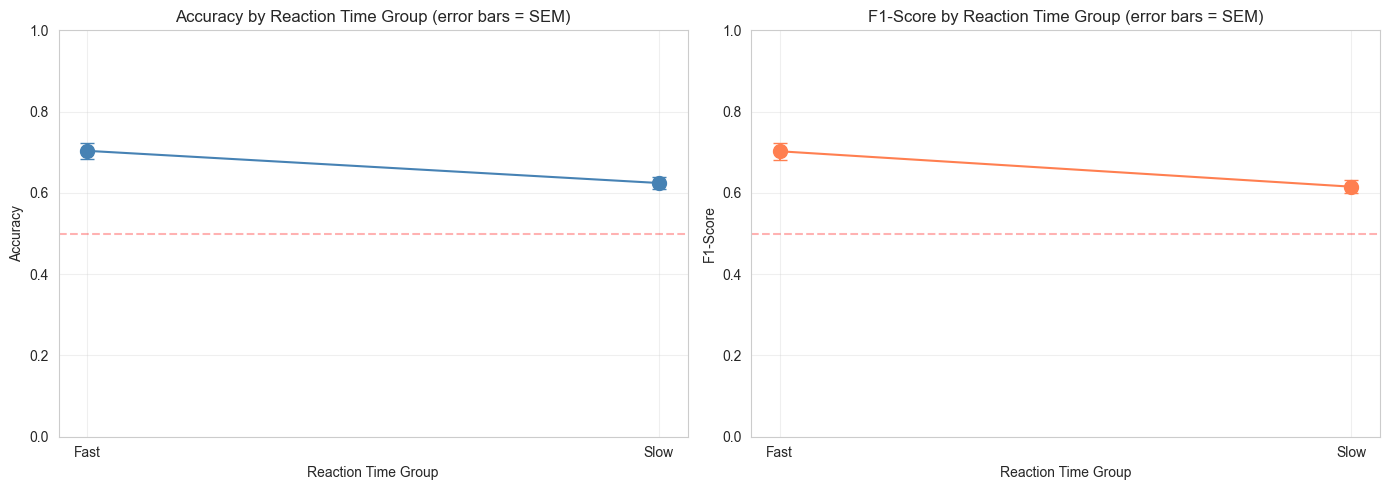

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax = axes[0]
ax.errorbar(comparison_df['Group'], comparison_df['Accuracy'], 
            yerr=comparison_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue', markersize=10)
ax.set_xlabel('Reaction Time Group')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Reaction Time Group (error bars = SEM)')
ax.set_ylim([0, 1])
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax.grid(alpha=0.3)

# F1-Score
ax = axes[1]
ax.errorbar(comparison_df['Group'], comparison_df['F1-Score'], 
            yerr=comparison_df['F1_SEM'], fmt='o-', capsize=5, color='coral', markersize=10)
ax.set_xlabel('Reaction Time Group')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Reaction Time Group (error bars = SEM)')
ax.set_ylim([0, 1])
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Subject-Level Accuracy Distributions


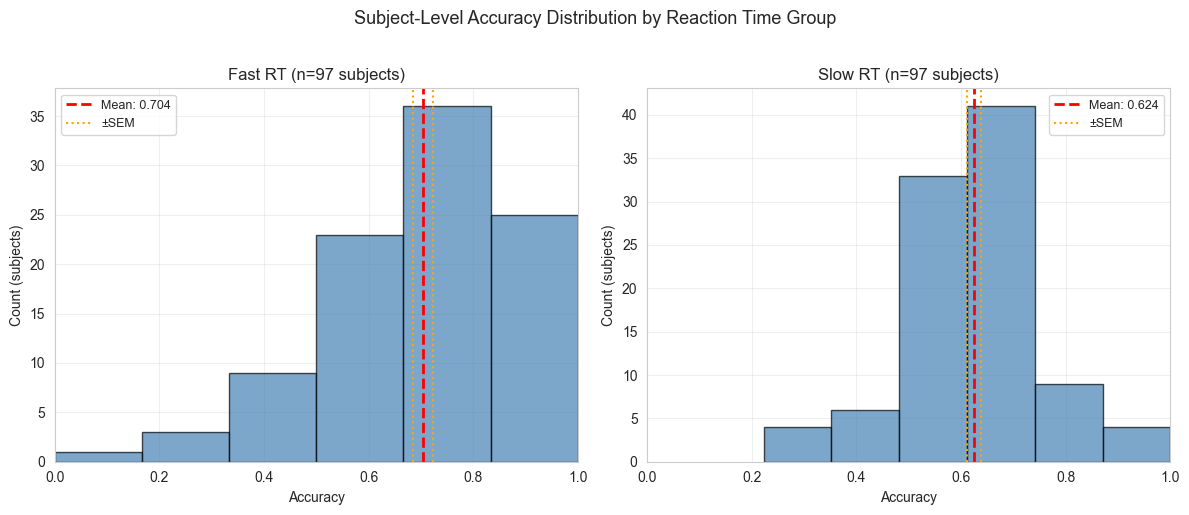

In [ ]:
# Plot subject-level accuracy distributions for each RT group
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (group, results) in enumerate(group_results.items()):
    ax = axes[idx]
    subject_accs = results['accuracy_per_subject']
    
    # Histogram
    ax.hist(subject_accs, bins=6, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(results['accuracy_mean'], color='red', linestyle='--', linewidth=2,
               label=f"Mean: {results['accuracy_mean']:.3f}")
    ax.axvline(results['accuracy_mean'] - results['accuracy_sem'], color='orange',
               linestyle=':', linewidth=1.5, label=f"±SEM")
    ax.axvline(results['accuracy_mean'] + results['accuracy_sem'], color='orange',
               linestyle=':', linewidth=1.5)
    
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Count (subjects)')
    ax.set_title(f'{group} RT (n={results["n_subjects"]} subjects)')
    ax.set_xlim([0, 1])
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Subject-Level Accuracy Distribution by Reaction Time Group', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


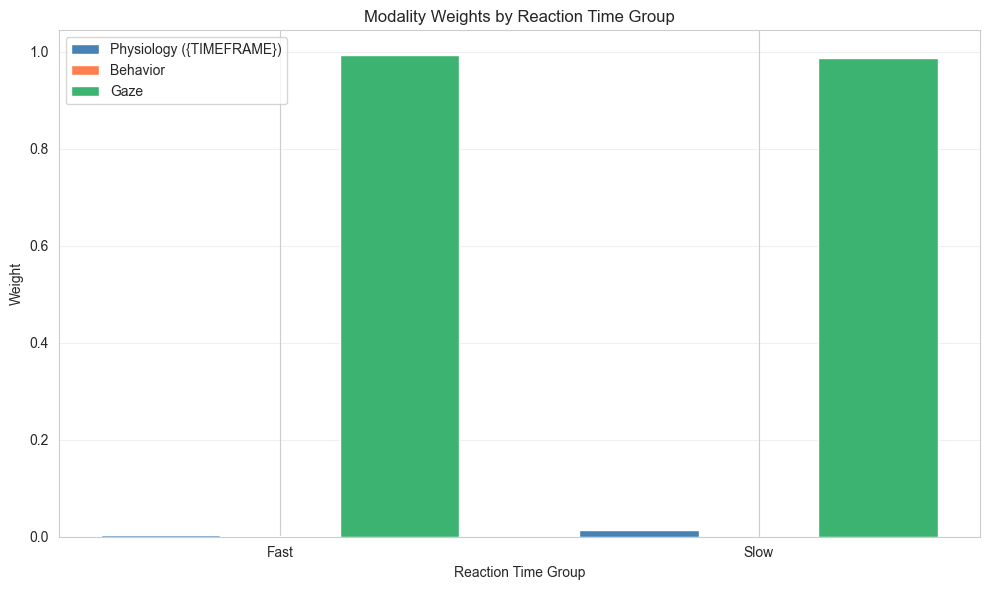

In [ ]:
# Modality weights by group
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Physiology_Weight'], width, 
       label='Physiology ({TIMEFRAME})', color='steelblue')
ax.bar(x, comparison_df['Behavior_Weight'], width, 
       label='Behavior', color='coral')
ax.bar(x + width, comparison_df['Gaze_Weight'], width, 
       label='Gaze', color='mediumseagreen')

ax.set_xlabel('Reaction Time Group')
ax.set_ylabel('Weight')
ax.set_title('Modality Weights by Reaction Time Group')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Group'])
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Save Results to CSV

Exporting all results for later analysis without re-running.

In [ ]:
import os
os.makedirs(f'../../data/results/fusion_model_results_{TIMEFRAME}', exist_ok=True)
# Save comparison results across groupsif 'comparison_df' in locals() and comparison_df is not None:    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_balanced_{TIMEFRAME}_comparison.csv'    comparison_df.to_csv(output_file, index=False)    print(f"✓ Saved comparison results to: {output_file}")    print(f"  Contains {len(comparison_df)} groups")# Save detailed group resultsif 'group_results' in locals() and group_results:    for group_name, results in group_results.items():        # Save modality weights        weights_df = pd.DataFrame({            'Modality': results.get('modality_names', ['Physiology', 'Behavior', 'Gaze']),            'Weight': results.get('weights', [0, 0, 0])        })        weights_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_balanced_{TIMEFRAME}_{group_name}_weights.csv'        weights_df.to_csv(weights_file, index=False)        # Save subject-level accuracies if available        if 'accuracy_per_subject' in results:            subject_df = pd.DataFrame({                'accuracy': results['accuracy_per_subject'],                'f1_score': results.get('f1_per_subject', [])            })            subject_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_balanced_{TIMEFRAME}_{group_name}_subject_accuracies.csv'            subject_df.to_csv(subject_file, index=False)    print(f"✓ Saved detailed results for {len(group_results)} groups")print(f"\nAll results saved to: ../../data/results/fusion_model_results_{TIMEFRAME}/")
# Save comparison results across groups
if 'comparison_df' in locals() and comparison_df is not None:
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_balanced_{TIMEFRAME}_comparison.csv'
    comparison_df.to_csv(output_file, index=False)
    print(f"✓ Saved comparison results to: {output_file}")
    print(f"  Contains {len(comparison_df)} groups")

# Save detailed group results
if 'group_results' in locals() and group_results:
    for group_name, results in group_results.items():
        # Save modality weights
        weights_df = pd.DataFrame({
            'Modality': results.get('modality_names', ['Physiology', 'Behavior', 'Gaze']),
            'Weight': results.get('weights', [0, 0, 0])
        })
        weights_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_balanced_{TIMEFRAME}_{group_name}_weights.csv'
        weights_df.to_csv(weights_file, index=False)

        # Save subject-level accuracies if available
        if 'accuracy_per_subject' in results:
            subject_df = pd.DataFrame({
                'accuracy': results['accuracy_per_subject'],
                'f1_score': results.get('f1_per_subject', [])
            })
            subject_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_balanced_{TIMEFRAME}_{group_name}_subject_accuracies.csv'
            subject_df.to_csv(subject_file, index=False)

    print(f"✓ Saved detailed results for {len(group_results)} groups")

print(f"\nAll results saved to: ../../data/results/fusion_model_results_{TIMEFRAME}/")

✓ Saved comparison results to: ../../data/results/fusion_model_results_PRE/reaction_time_group_late_fusion_balanced_PRE_comparison.csv
  Contains 2 groups
✓ Saved detailed results for 2 groups

All results saved to: ../../data/results/fusion_model_results_PRE/
